
# Support Vector Machines in Python for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **support vector machine modeling in Python**.  We have included in our workflow some simple wrappers and reimplementations of GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). Support vector machines are a powerful method for machine learning classification.  The support vector machine is a generalization of the maximal margin classifier that deals with cateogries that cannot be separated linearly.   

This exercise demonstrates the support vector machine approach in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. generate a 2D sequential Guassian simulation using a wrapper of GSLIB's sgsim method
2. add a trend (to simplify the segmentation problem) and truncate to build a categorical, exhaustive truth model
3. extract random samples from the truth model
4. separate into training and testing (20%) datasets
5. build support vector machine classifiers with simple linear and polynomial kernels
6. tune the "C" coefficient for the polynomial model with k-fold cross validation
7. compare the tuned, polynomial model with the simple linear kernel model with confusion matrices

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods.  Only the sgsim, locpix are used for this workflow:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods
6. varmap - vairogram map
7. gam -regularly sampled data variograms
8. gamv - irregularly sampled data variograms
9. nscore - normal score transform (data transformation to Gaussian with a mean of zero and a standard deviation of one)

These methods are all in the functions declared upfront. To run this demo all one has to do is download and place in your working directory the following executables from the GSLIB/bin directory:

1. sgsim.exe

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python, geostatistics nor machine learning experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes in my class.  The Python code and markdown was developed and tested in Jupyter. 

#### Project Goal

Prediction of categories, low or high porosity, away from sample data values over the are of interest.

#### Load the required libraries

The following code loads the required libraries.


In [143]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
from sklearn.model_selection import train_test_split      # training and testing datasets
from sklearn.metrics import confusion_matrix              # for sumarizing model performance
import itertools                                          # assist with iteration used in plot_confusion_matrix

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with 4 utilities to move between GSLIB's Geo-EAS data sets and DataFrames, and grids and 2D Numpy arrays respectively and 2 utilities to resample from regular datasets.  Available GSLIB functions include:

1. hist
2. pixelplt
3. locmap
4. locpix
5. vargplt
6. affine
7. nscore
8. declus
9. gam
10. gamv
11. vmodel
12. sgsim
13. visualize_model - to visualize the machine learning solution space
14. plot_svc_decision_function - visualize the model with margins included
15. plot_confusion_matrix - plot confusion matrix

For now we embed the functions in the workflow below. In the future this will be turned into a proper Python package.  Warning, there has been no attempt to make these functions robust in the precense of bad inputs.  If you get a crazy error check the inputs.  Are the arrays empty and are they the same size when they should be?  Are the arrays the correct dimension?  Is the parameter order mixed up?  Make sure the inputs are consistent with the descriptions in this document.

In [144]:
# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    import os
    import numpy as np  
    import pandas as pd

    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df
    
# utility to convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB methods
def Dataframe2GSLIB(data_file,df):
    colArray = []
    colArray = df.columns
    ncol = len(df.columns) 
    nrow = len(df.index)
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write(str(ncol) + '\n') 
    for icol in range(0, ncol): 
        file_out.write(df.columns[icol]  + '\n')  
    
    for irow in range(0, nrow):
        for icol in range(0, ncol):
            file_out.write(str(df.iloc[irow,icol])+ ' ')  
        file_out.write('\n')

    file_out.close()    

# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(nx,ny),dtype=float,order='F')
    else:
        array = np.zeros(nx)
        
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name

# utility to convert numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        nx = array.shape[0]
        ny = array.shape[1]
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')  
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")
        return            
    file_out.close()
    
# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return
   
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

def vargplt(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    im = 0
    if type(lag)==type(list()):
        if vtype==0:
            im = plt.scatter(lag,gamma,s=None, c=npair, marker=None, label = name,cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
        else:
            plt.plot(lag,gamma,'C3',lw=3,c='black')
    else:
        nvar = lags.shape[0]
        for ivar in range(0, nvar):
            if vtype[ivar]==0:
                im = plt.scatter(lag[ivar],gamma[ivar],s=None,label = name[ivar],c=npair[ivar], marker=marker[ivar], cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
            else:
                plt.plot(lag[ivar],gamma[ivar], 'C3', lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (m)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    if im != 0:
        cbar = plt.colorbar(im, orientation = 'vertical')
        cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im

# pixelplt with location map superimposed, reimplementation in Python of a MOD from GSLIB with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step)) 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax, levels=np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.xlim(xmin,xmax-step)
    plt.ylim(ymin+step,ymax) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    ndarray2GSLIB(x,"nscore.dat","value")
    
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()

    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# cell-based declustering, 2D wrapper for declus from GSLIB (.exe must be in working directory)
def declus(df,xcol,ycol,vcol,cmin,cmax,cnum,bmin):
    import os
    import numpy as np
    nrow = len(df)
    weights = []
    file = 'declus_out.dat'
    file_out = open(file, "w")
    file_out.write('declus_out.dat' + '\n')  
    file_out.write('3' + '\n')  
    file_out.write('x' + '\n') 
    file_out.write('y' + '\n')
    file_out.write('value' + '\n')  
    for irow in range(0, nrow):
        file_out.write(str(df.iloc[irow][xcol])+' '+str(df.iloc[irow][ycol])+' '+str(df.iloc[irow][vcol])+' \n')        
    file_out.close()
    
    file = open("declus.par", "w")
    file.write("                  Parameters for DECLUS                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("declus_out.dat           -file with data                                   \n")
    file.write("1   2   0   3               -  columns for X, Y, Z, and variable           \n")
    file.write("-1.0e21     1.0e21          -  trimming limits                             \n")
    file.write("declus.sum                  -file for summary output                       \n") 
    file.write("declus.out                  -file for output with data & weights           \n")
    file.write("1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)    \n") 
    file.write(str(bmin) + "                -0=look for minimum declustered mean (1=max)   \n") 
    file.write(str(cnum) + " " + str(cmin) + " " + str(cmax) + " -number of cell sizes, min size, max size      \n")
    file.write("5                           -number of origin offsets                      \n")
    file.close()
    
    os.system('declus.exe declus.par')
    df = GSLIB2Dataframe("declus.out")
    for irow in range(0, nrow):
        weights.append(df.iloc[irow,3])    

    return(weights)
 
# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gam_2d(array,nx,ny,hsiz,nlag,xlag,ylag,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    ndarray2GSLIB(array,"gam_out.dat","gam.dat")
    
    file = open("gam.par", "w")
    file.write("                  Parameters for GAM                                       \n")
    file.write("                  ******************                                       \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gam_out.dat           -file with data                                      \n")
    file.write("1   1   0             -   number of variables, column numbers              \n")
    file.write("-1.0e21     1.0e21    -   trimming limits                                  \n")
    file.write("gam.out               -file for variogram output                           \n")
    file.write("1                     -grid or realization number                          \n")
    file.write(str(nx) + " 0.0 " + str(hsiz) + "  -nx, xmn, xsiz                           \n")
    file.write(str(ny) + " 0.0 " + str(hsiz) + "  -ny, ymn, ysiz                           \n")
    file.write(" 1   0.5   1.0        -nz, zmn, zsiz                                       \n")
    file.write("1 " + str(nlag) + "   -number of directions, number of lags                \n")
    file.write(str(xlag) + " " + str(ylag) + " 0 -ixd(1),iyd(1),izd(1)                     \n")
    file.write("1                     -standardize sill? (0=no, 1=yes)                     \n")
    file.write("1                     -number of variograms                                \n")
    file.write("1   1   1             -tail variable, head variable, variogram type        \n") 
    file.close()
    
    os.system('gam.exe gam.par')
    reading = True
    with open("gam.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(head[0].split()[1])
                gamma.append(head[0].split()[2])
                npair.append(head[0].split()[3])
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# regular grid variogram, 2D wrapper for gam from GSLIB (.exe must be in working directory)
def gamv_2d(df,xcol,ycol,vcol,nlag,lagdist,azi,atol,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("gamv_out.dat",df_ext)
    
    file = open("gamv.par", "w")
    
    file.write("                  Parameters for GAMV                                      \n")
    file.write("                  *******************                                      \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gamv_out.dat                    -file with data                            \n") 
    file.write("1   2   0                         -   columns for X, Y, Z coordinates      \n")
    file.write("1   3   0                         -   number of variables,col numbers      \n")
    file.write("-1.0e21     1.0e21                -   trimming limits                      \n")
    file.write("gamv.out                          -file for variogram output               \n")
    file.write(str(nlag) + "                      -number of lags                          \n")
    file.write(str(lagdist) + "                       -lag separation distance                 \n")
    file.write(str(lagdist*0.5) + "                   -lag tolerance                           \n")
    file.write("1                                 -number of directions                    \n")
    file.write(str(azi) + " " + str(atol) + " 99999.9 0.0  90.0  50.0  -azm,atol,bandh,dip,dtol,bandv \n")
    file.write(str(bstand) + "                    -standardize sills? (0=no, 1=yes)        \n")
    file.write("1                                 -number of variograms                    \n")
    file.write("1   1   1                         -tail var., head var., variogram type    \n")
    file.close()
    
    os.system('gamv.exe gamv.par')
    reading = True
    with open("gamv.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(head[0].split()[1])
                gamma.append(head[0].split()[2])
                npair.append(head[0].split()[3])
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)    

# irregular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmapv_2d(df,xcol,ycol,vcol,nx,ny,lagdist,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    df_ext = pd.DataFrame({'X':df[xcol],'Y':df[ycol],'Z':rand_sample[vcol]})
    Dataframe2GSLIB("varmap_out.dat",df_ext)
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   3                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("0                            -1=regular grid, 0=scattered values           \n")
    file.write(" 50   50    1                -if =1: nx,     ny,   nz                      \n")
    file.write("1.0  1.0  1.0                -       xsiz, ysiz, zsiz                      \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nx) + " " + str(ny) + " 0 " + "-nxlag, nylag, nzlag                     \n")
    file.write(str(lagdist) + " " + str(lagdist) + " 1.0              -dxlag, dylag, dzlag \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nx*2+1; nny = ny*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nx)+0.5)*lagdist); xmin = -1*xmax; 
    ymax = ((float(ny)+0.5)*lagdist); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,lagdist,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  

# regular spaced data, 2D wrapper for varmap from GSLIB (.exe must be in working directory)
def varmap_2d(array,nx,ny,hsiz,nlagx,nlagy,minpairs,vmax,bstand,title,vlabel):
    import os
    import numpy as np
     
    ndarray2GSLIB(array,"varmap_out.dat","gam.dat")
    
    file = open("varmap.par", "w")
    
    file.write("              Parameters for VARMAP                                        \n")
    file.write("              *********************                                        \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("varmap_out.dat          -file with data                                    \n")
    file.write("1   1                        -   number of variables: column numbers       \n")
    file.write("-1.0e21     1.0e21           -   trimming limits                           \n")
    file.write("1                            -1=regular grid, 0=scattered values           \n")
    file.write(str(nx) + " " + str(ny) + " 1  -if =1: nx,     ny,   nz                     \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0  - xsiz, ysiz, zsiz                     \n") 
    file.write("1   2   0                    -if =0: columns for x,y, z coordinates        \n") 
    file.write("varmap.out                   -file for variogram output                    \n")
    file.write(str(nlagx) + " " + str(nlagy) + " 0 " + "-nxlag, nylag, nzlag               \n")
    file.write(str(hsiz) + " " + str(hsiz) + " 1.0              -dxlag, dylag, dzlag       \n")
    file.write(str(minpairs) + "             -minimum number of pairs                      \n")
    file.write(str(bstand) + "               -standardize sill? (0=no, 1=yes)              \n")
    file.write("1                            -number of variograms                         \n") 
    file.write("1   1   1                    -tail, head, variogram type                   \n")
    file.close()
    
    os.system('varmap.exe varmap.par')
    nnx = nlagx*2+1; nny = nlagy*2+1
    varmap, name = GSLIB2ndarray("varmap.out",0,nnx,nny)               
          
    xmax = ((float(nlagx)+0.5)*hsiz); xmin = -1*xmax; 
    ymax = ((float(nlagy)+0.5)*hsiz); ymin = -1*ymax; 
    pixelplt(varmap,xmin,xmax,ymin,ymax,hsiz,0,vmax,title,'X','Y',vlabel,cmap)
    return(varmap)  


# variogram model, 2D wrapper for vmodel from GSLIB (.exe must be in working directory)
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(head[0].split()[1])
                gamma.append(head[0].split()[2])
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)                
               
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

# extract random set of samples from a model   
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    nx = xx.shape[0]
    ny = xx.shape[1]
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[ix,iy])
        y.append(yy[ix,iy])
        v.append(array[ix,iy])
   
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)  

def visualize_model(model,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 10.0
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    #plt.show()
    return(plt)
    
def plot_svc_decision_function(model,plt,xmin,xmax,ymin,ymax, plot_support=True): # modified from Jake VanderPlas's Python Data Science Handbook  
    """Plot the decision function for a 2D SVC"""
    xlim = [xmin,xmax]
    ylim = [ymin,ymax]
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    plt.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=3, linewidth=15, facecolors='black');
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    
def plot_confusion_matrix(cm, classes, # from scikit-learn docs on confusion matrix
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [3]:
os.chdir("c:/PGE337/Variogram")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  We then add a y-coordinate trend and then trauncate the continuous simulation into 1 - high porosity and -1 - low porosity. We are keeping this workflow simple. *This is our exhaustive, truth model that we will sample*.  We added the trend to create a region of low at the top of the model and a region of high at the base of the model.  The resulting truth data set can be segmented with linear and low order polynomial kernels.  

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

In [4]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 75075                                                     # random number seed  for stochastic simulation    
range_max = 1000; range_min = 800; azimuth = 90                  # Porosity variogram ranges and azimuth
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.

Now let's add a y-direction trend and truncate into 2 categoeries -1 and 1, where 1 is high porosity and -1 is low porosity.

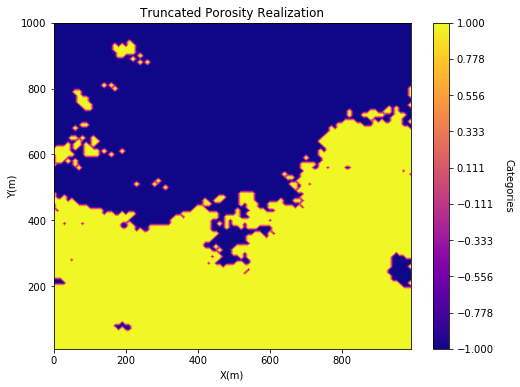

In [5]:
csim = np.zeros((nx,ny))                                         # declare a new 2D array
threshold = 10.0; trend_range = 10                               # set a threshold and trend magnitude
for iy in range(0, ny):                                          # add trend and stochastic residual and truncate
    for ix in range(0, nx):
        sim[ix,iy] = sim[ix,iy] + (ix-50)/100 * trend_range 
        if(sim[ix,iy]<threshold):
            csim[ix,iy] = -1
        else:
            csim[ix,iy] = 1    
        
pixelplt(csim,xmin,xmax,ymin,ymax,cell_size,-1,1,"Truncated Porosity Realization","X(m)","Y(m)","Categories",cmap)

Now let's extract some data samples from our truth model to train and test our support vector machine classification model and separate into training (80%) and testing (20%) subsets.

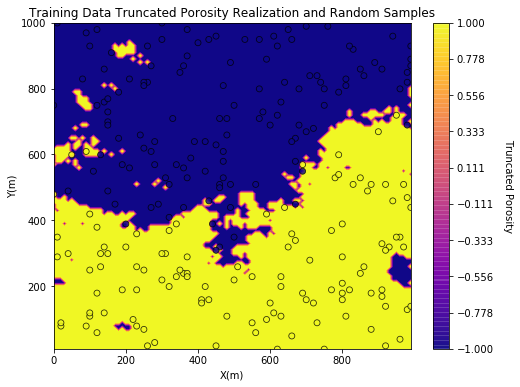

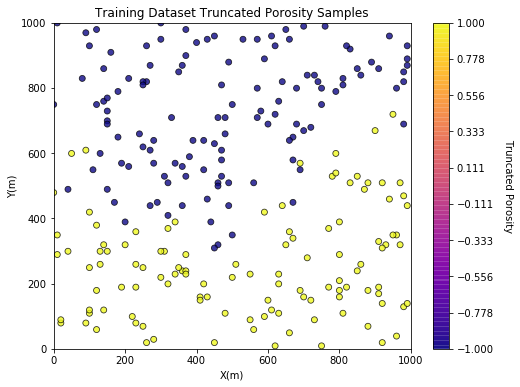

In [91]:
rand_sample = random_sample(csim,xmin,xmax,ymin,ymax,cell_size,300,"TPorosity")
train, test = train_test_split(rand_sample, test_size=0.2)
locpix(csim,xmin,xmax,ymin,ymax,cell_size,-1,1,train,'X','Y','TPorosity','Training Data Truncated Porosity Realization and Random Samples','X(m)','Y(m)','Truncated Porosity',cmap)
locmap(train,'X','Y','TPorosity',xmin,xmax,ymin,ymax,-1,1,'Training Dataset Truncated Porosity Samples','X(m)','Y(m)','Truncated Porosity',cmap)

Here's the testing data that we will with hold.  

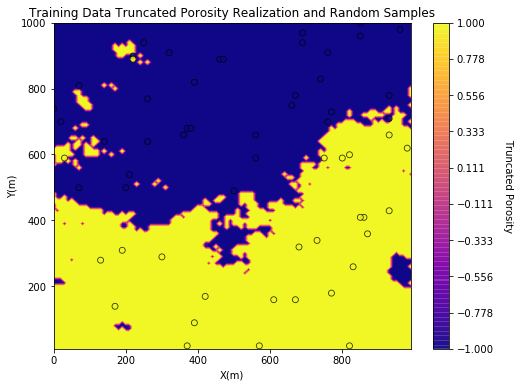

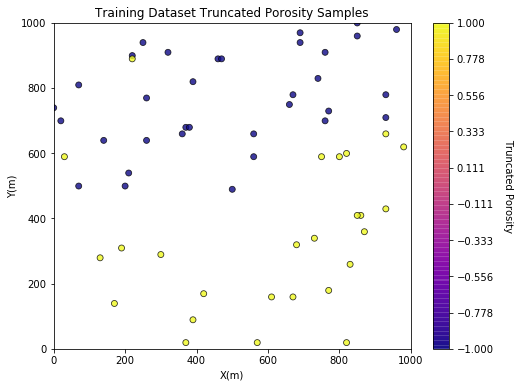

In [92]:
locpix(csim,xmin,xmax,ymin,ymax,cell_size,-1,1,test,'X','Y','TPorosity','Testing Dataset Truncated Porosity Realization and Random Samples','X(m)','Y(m)','Truncated Porosity',cmap)
locmap(test,'X','Y','TPorosity',xmin,xmax,ymin,ymax,-1,1,'Testing Dataset Truncated Porosity Samples','X(m)','Y(m)','Truncated Porosity',cmap)

It's a good idea to look at the summary statistics of our training data.

In [93]:
train.describe().transpose()                               # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
X,240.0,503.666667,287.173306,0.0,260.0,480.0,750.0,990.0
Y,240.0,501.166667,288.061428,9.0,246.5,509.0,751.5,999.0
TPorosity,240.0,-0.041667,1.001220,-1.0,-1.0,-1.0,1.0,1.0


We observed that the sampled data exist between 0 and 1,000 in both X and Y coordinates and that the truncated Porosity (TPorosity) variable is categorical -1 or 1.  It would be trivial to calculate the proportion of high ($prop_{high}$) and low ($prop_{low}$) porosity.    

$m = prop_{high} \times 1 + prop_{low} \times -1$

$prop_{high} = \frac{m + 1}{2} = \frac{-0.04 + 1}{2} = 0.48$

$prop_{low} = 1 - prop_{high} = 1 - 0.48 = 0.52$

We need to reformat our data to inputs to train the support vector machine.  Now we will extract the features (X and Y) into an array,

In [128]:
train_X = train.iloc[:,0:2]
train_X[:7]

,X,Y
275,320.0,369.0
276,140.0,759.0
193,50.0,599.0
255,800.0,209.0
144,370.0,289.0
75,150.0,299.0
278,470.0,809.0


and the cateogrical response (truncated porosity) into separate arrays.

In [129]:
train_Y = train.iloc[:,2:3]
train_Y[:7]

,TPorosity
275,1.0
276,-1.0
193,1.0
255,1.0
144,1.0
75,1.0
278,-1.0


Let's train and plot linear and polynomial kernel support vector machine models over our solution space.  This will provide a spatial classification model for porosity low or high as a function of X and Y location.  We will start with a linear kernel.  

[LibSVM]

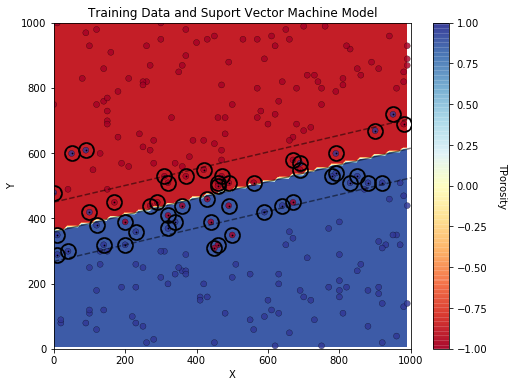

In [130]:
from sklearn import svm
C = 1.0
svm_linear = svm.SVC(kernel = 'linear',C = C, verbose = True)
svm_linear.fit(train_X,train_Y["TPorosity"]) 
plt = visualize_model(svm_linear,train_X["X"],train_X["Y"],train_Y["TPorosity"],'Training Data and Suport Vector Machine Model')
plot_svc_decision_function(svm_linear,plt,xmin,xmax,ymin,ymax, plot_support=True)

The above plot shows the linear kernel support vector machine classification model (low porosity is red and high porosity is blue), the training dataset, margin outlined with dashed lines, and the resulting support vectors circled.  Note the support vectors impact the decision boundary as they are either in the margin, between the dashed lines, or misclassified outside the margin. It looks like we have quite a bit misclassication.

Let's try a more complicated, flexible classifier with a polynomial kernel.  Recall, there is a trade off as more complexity reduces model bias (error due to a simple model not fitting the actual data), but increases model variance (sensitivity to training data).

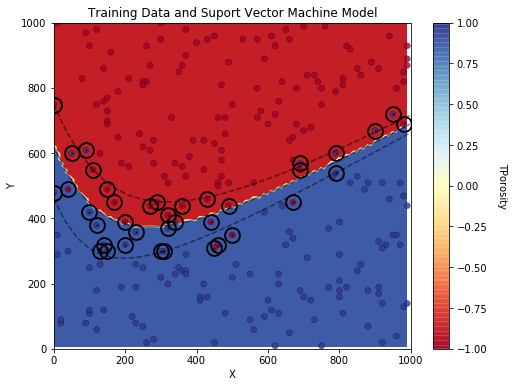

In [166]:
from sklearn import svm
C = 0.000001
svm_poly = svm.SVC(kernel = 'poly', degree = 2, max_iter = 100000000, C = C)
svm_poly.fit(train_X,train_Y["TPorosity"]) 
plt = visualize_model(svm_poly,train_X["X"],train_X["Y"],train_Y["TPorosity"],'Training Data and Suport Vector Machine Model')
plot_svc_decision_function(svm_poly,plt,xmin,xmax,ymin,ymax, plot_support=True)

This model seems to work well for this problem.  The $2^{nd}$ order polynomial should have pretty low model variance.   Recall the "C" coefficient tunes the width of the margin; therefore, controls the number of support vectors / sample data the impact the model.  The dashed line above show a wide margin with a lot of points in the margin included as support vectors.  Let's try a dramatically higher "C" coefficient value.   

C:\Users\pm27995\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


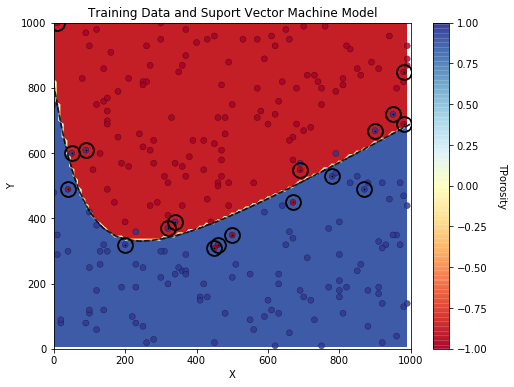

In [210]:
C = 1.0
svm_poly = svm.SVC(kernel = 'poly', degree = 2, max_iter = 100000000, C = C)
svm_poly.fit(train_X,train_Y["TPorosity"]) 
plt = visualize_model(svm_poly,train_X["X"],train_X["Y"],train_Y["TPorosity"],'Training Data and Suport Vector Machine Model')
plot_svc_decision_function(svm_poly,plt,xmin,xmax,ymin,ymax, plot_support=True)

With a "C" coefficient of 1.0 we now have much fewer support vectors, but the model is very similar.  Let's apply k-fold cross validation to tune the "C" coefficient.  We use the default of 3-fold cross validation.

C:\Users\pm27995\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\pm27995\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\pm27995\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\pm27995\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing yo

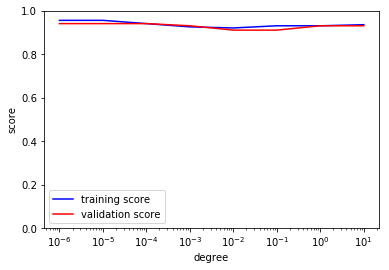

In [209]:
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve

all_X = rand_sample.iloc[:,0:2].as_matrix()
all_Y = rand_sample.iloc[:,2].as_matrix()

C_range = np.transpose(np.c_[0.000001,0.00001,0.0001,0.001,0.01,0.1,1.0,10.0]) # the attempted "C" coefficients. 

train_score, val_score = validation_curve(svm_poly, all_X, all_Y,'C', C_range)

plt.semilogx(C_range, np.median(train_score, 1), color='blue', label='training score')
plt.semilogx(C_range, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');
plt.show()

The validation score with the testing data and the training score are maximum with "C" coefficients around $10^{-6}$ to $10^{-5}$. We will retain that model.  We run it again below.

In [ ]:
from sklearn import svm
C = 0.000001
svm_poly = svm.SVC(kernel = 'poly', degree = 2, max_iter = 100000000, C = C)
svm_poly.fit(train_X,train_Y["TPorosity"]) 
plt = visualize_model(svm_poly,train_X["X"],train_X["Y"],train_Y["TPorosity"],'Training Data and Suport Vector Machine Model')
plot_svc_decision_function(svm_poly,plt,xmin,xmax,ymin,ymax, plot_support=True)

Now lets summarize the performance of our classification models, let's calculate and visualize confusion matrices for both the linear and tuned, polynomial kernel models for the training and the testing datasets.  Here's the result for the linear kernel for the training and testing datasets.

Confusion matrix, without normalization
[[115  10]
 [  8 107]]


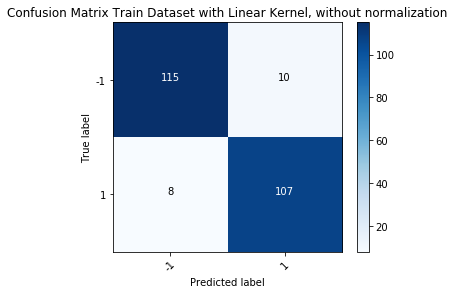

Confusion matrix, without normalization
[[34  0]
 [ 7 19]]


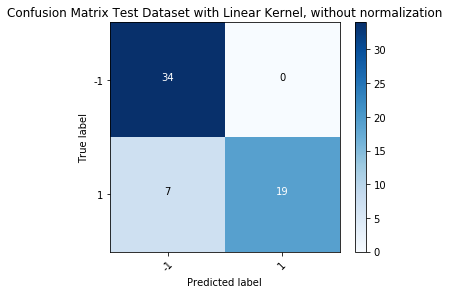

In [150]:
test_X = test.iloc[:,0:2]
test_Y = test.iloc[:,2:3]

train_linear_predict = svm_linear.predict(train_X)          # get the classifications for the training dataset
cnf_train_linear_matrix = confusion_matrix(train_Y, train_linear_predict) # build the confusion matrix

test_linear_predict = svm_linear.predict(test_X)            # get the classifications for the testing dataset
cnf_test_linear_matrix = confusion_matrix(test_Y, test_linear_predict) # build the confusion matrix

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_train_linear_matrix, classes=[-1,1],
                      title='Confusion Matrix Train Dataset with Linear Kernel, without normalization')
plt.show()
plt.figure()
plot_confusion_matrix(cnf_test_linear_matrix , classes=[-1,1],
                      title='Confusion Matrix Test Dataset with Linear Kernel, without normalization')
plt.show()

Here's the result for our best model, the tuned, polynomial kernel for the training and testing datasets.

Confusion matrix, without normalization
[[119   6]
 [  9 106]]


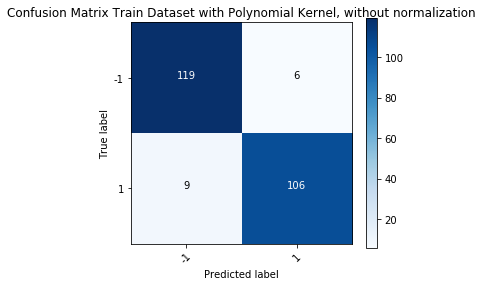

Confusion matrix, without normalization
[[33  1]
 [ 5 21]]


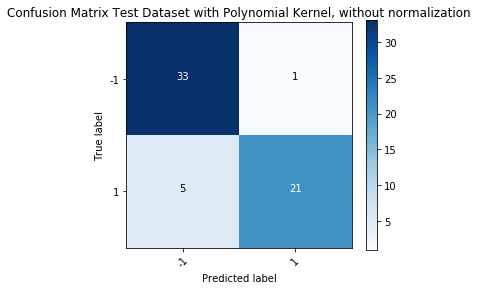

In [151]:
test_X = test.iloc[:,0:2]
test_Y = test.iloc[:,2:3]

train_poly_predict = svm_poly.predict(train_X)          # get the classifications for the training dataset
cnf_train_poly_matrix = confusion_matrix(train_Y, train_poly_predict) # build the confusion matrix

test_poly_predict = svm_poly.predict(test_X)            # get the classifications for the testing dataset
cnf_test_poly_matrix = confusion_matrix(test_Y, test_poly_predict) # build the confusion matrix

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_train_poly_matrix, classes=[-1,1],
                      title='Confusion Matrix Train Dataset with Polynomial Kernel, without normalization')
plt.show()
plt.figure()
plot_confusion_matrix(cnf_test_poly_matrix , classes=[-1,1],
                      title='Confusion Matrix Test Dataset with Polynomial Kernel, without normalization')
plt.show()

One can observe a minor improvement in performance for the tuned, polynomial kernel support vector machine over the untuned, simpler linear kernel model.  

#### More Exercises

There are so many more exercises and tests that one could attempt to gain experience with support vector machines in Python. I'll end here for brevity, but I invite you to continue. Consider, on your own applying other data sets or attempting use of different kernels.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
